# EuroCrops Demo

This notebook assists with exploring the EuroCrops demo dataset.


### Imports

In [1]:
from dataclasses import dataclass
import datetime as dt
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm


%matplotlib inline

### Load Data

In [2]:
ROOT_DATA_PATH = '/media/data/local/eurocrops/m1615987/'
H5_FILE_PATH = os.path.join(ROOT_DATA_PATH, 'HDF5s/train/AT_T33UWP_train.h5')

In [3]:
NUMBER_OF_CHANNELS = 13

In [4]:
hdf = pd.HDFStore(H5_FILE_PATH, mode='r') #here we directly load the .h5 file in one go using pandas.
region_names = hdf.keys()  #list all the keys or regions in the region (for eg- AT112)

In [5]:
df_datas = []

for region_name in tqdm(region_names):
    df_data_single = hdf.get(f'/{region_name}') #selecting a region from based on the key (AT112 for eg.)
    df_datas.append(df_data_single)

In [6]:
#len(set.union(*[set(x.columns) for x in df_datas]))  120 columns now, but for one region there are only 80, intesection 44
#len(set.intersection(*[set(x.columns) for x in df_datas]))  # 120 columns now, but for one region there are only 80

In [7]:
# Conatenation of data with different dates - fixed interval span, with finding closes date (better to use interpolation, but not with nois cloud data)
DI = 6  # days interval
common_days = list(range(DI, 365, DI))
print(f'len(common_days) = {len(common_days)}')
# common_days_datetime = [for day in common_days]

# year = int(timesteps[10][:4])
# new_year_day = dt.datetime(year=year, month=1, day=1)
# dates_list = [((dt.datetime.strptime(date, tf)- new_year_day).days + 1) for date in timesteps]

df_data_all = pd.DataFrame(columns=common_days)


for df_data_single in tqdm(df_datas[:]):
    timesteps = list(df_data_single.columns)
    year = int(timesteps[10][:4])
    new_year_day = dt.datetime(year=year, month=1, day=1)
    tf = '%Y%m%d'
    dates_list = [((dt.datetime.strptime(date, tf)- new_year_day).days + 1) for date in timesteps]
    df_data_single = df_data_single.rename(columns={old: new for old, new in zip(timesteps, dates_list)})

    closest_columns = []
    for common_day in common_days:
        closest_column = np.argmin([abs(common_day - v) for v in dates_list])
        closest_columns.append(closest_column)
    
    new_frames = []
    for index, row in df_data_single.iterrows():
        resampled_row_data = [row.iloc[closest_column] for closest_column in closest_columns]
        resampled_row_df = pd.DataFrame([resampled_row_data], columns=common_days, index=[index])
        new_frames.append(resampled_row_df)
    
    new_frames_df = pd.concat(new_frames)
    df_data_all = pd.concat([df_data_all, new_frames_df])


100%|███████████████████████████████████████████████████████████████████████████| 8/8 [10:49<00:00, 81.23s/it]


In [8]:
df_data_all.head(1)

,6,12,18,24,30,36,42,48,54,60,...,306,312,318,324,330,336,342,348,354,360
463,"[3871, 3600, 2992, 3105, 3205, 3320, 3321, 348...","[1638, 1193, 780, 647, 692, 732, 763, 680, 545...","[6992, 6542, 5944, 6414, 6786, 6859, 6973, 674...","[6992, 6542, 5944, 6414, 6786, 6859, 6973, 674...","[1456, 1079, 767, 673, 737, 796, 851, 772, 472...","[1456, 1079, 767, 673, 737, 796, 851, 772, 472...","[1511, 1079, 694, 540, 541, 580, 586, 538, 302...","[1556, 1172, 916, 862, 934, 1056, 1137, 1059, ...","[1968, 1501, 1274, 1269, 1304, 1461, 1601, 142...","[1492, 1114, 866, 818, 895, 995, 1079, 1000, 6...",...,"[1449, 1115, 789, 666, 674, 724, 786, 740, 256...","[1449, 1115, 789, 666, 674, 724, 786, 740, 256...","[1449, 1115, 789, 666, 674, 724, 786, 740, 256...","[3450, 3114, 2883, 3245, 3432, 3793, 4090, 364...","[2450, 2039, 1665, 1577, 1608, 1668, 1691, 160...","[1695, 1244, 889, 708, 763, 913, 966, 912, 343...","[1552, 1127, 692, 473, 442, 437, 421, 370, 159...","[1552, 1127, 692, 473, 442, 437, 421, 370, 159...","[1770, 1294, 898, 732, 802, 954, 1015, 953, 36...","[1608, 1196, 756, 582, 571, 603, 590, 563, 320..."


In [22]:
df_data_all.shape

(345970, 60)

#### Load the corresponding labels

In [9]:
df_labels_all_lists = []

for region_name in region_names:
    region_name = region_name.strip('/')
    LABELS_CSV_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'csv_labels/train/demo_eurocrops_{region_name}.csv')
    GEO_JSON_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'GeoJSONs_regional_split/train/AT/demo_eurocrops_{region_name}.geojson')

    # csv_file_path = os.path.join(train_csv_dir, csv_file_name)
    df_labels = pd.read_csv(LABELS_CSV_FILE_PATH, index_col=0)
    df_labels_all_lists.append(df_labels)
    
    
df_labels_all = pd.concat(df_labels_all_lists)
del df_labels_all_lists

### Check out the data

- **Rows**: parcel ID <br>
- **Cols**: timesteps <br>
- **Cells**: 13 representative reflectances (median value) for a parcel, each corresponding to one band of the *SENTIEL-2* Satellites.

In [10]:
df_labels_all.shape

(345970, 2)

In [11]:
df_labels_all

,crpgrpc,crpgrpn
recno,,
463,33111022,leguminous_plants
464,33111022,leguminous_plants
504,33111022,leguminous_plants
577,33111022,leguminous_plants
578,33111022,leguminous_plants
...,...,...
363647,33200000,pasture_meadow
363648,33200000,pasture_meadow
363676,33200000,pasture_meadow


### Check out the labels and metadata

- **id**: parcel ID
- **nuts_id**: NUTs-3 region name
- **crop_code**: code corresponding to the given crop name
- **crop_name**: name according to the EAGLE-matrix

In [12]:
df_labels_all.head()

,crpgrpc,crpgrpn
recno,,
463,33111022,leguminous_plants
464,33111022,leguminous_plants
504,33111022,leguminous_plants
577,33111022,leguminous_plants
578,33111022,leguminous_plants


### Check out the data for one parcel

In [13]:
# Pick the first row
example_row = df_data_all.iloc[0]
parcel_ID = example_row.name

# Get the corresponding label
label_code = df_labels_all.loc[parcel_ID]['crpgrpc']
label_name = df_labels_all.loc[parcel_ID]['crpgrpn']

print('{} grows on parcel {}'.format(label_name, parcel_ID))

leguminous_plants grows on parcel 463


### Look at the reflectance data for one parcel

#### Convert the timesteps into relative timestep

In [14]:
dates_list = common_days

#### Extract the row data into a numpy array

In [15]:
example_row = example_row.to_numpy()
example_row = np.stack(example_row, axis=0)

#### Plot the data

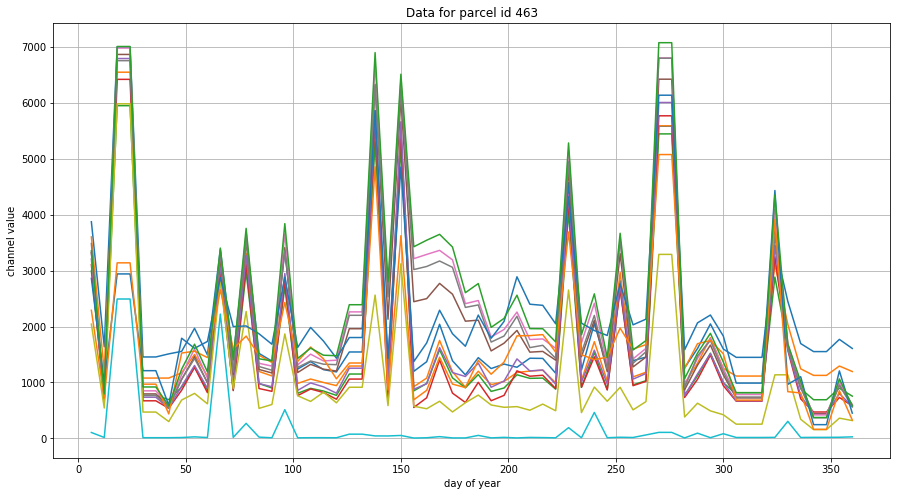

In [16]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(dates_list, example_row)
# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('channel value')
plt.title(f'Data for parcel id {parcel_ID}')
plt.grid()

#### Load geojson

In [17]:
geometry_dict_by_parcelid_all = {}

for region_name in tqdm(region_names):
    region_name = region_name.strip('/')
    GEO_JSON_FILE_PATH = os.path.join(ROOT_DATA_PATH, f'GeoJSONs_regional_split/train/AT/demo_eurocrops_{region_name}.geojson')    

    with open(GEO_JSON_FILE_PATH, 'r') as file:
        geojson_data = json.load(file)
    
    geometry_dict_by_parcelid = {feature['properties']['recno']: feature['geometry'] 
                                 for feature in geojson_data['features']}
    geometry_dict_by_parcelid_all.update(geometry_dict_by_parcelid)

100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.62s/it]


In [18]:
geometry_dict_by_parcelid_all[parcel_ID]

{'type': 'MultiPolygon',
 'coordinates': [[[[16.423795460623445, 47.82078105997216],
    [16.423021541535473, 47.82090602658277],
    [16.426825139832076, 47.82334122371044],
    [16.42726926945361, 47.82300513488749],
    [16.423795460623445, 47.82078105997216]]]]}

### Check crop types in the current dataset

In [19]:
regions_id_set = set(df_data_all.index)

In [20]:
crop_types_counts = {}
crop_types_ids = {}

for i, region_id in enumerate(df_labels_all.index):
    if region_id not in regions_id_set:
        continue
        
    crop_name = df_labels_all.iloc[i]['crpgrpn']
    current_count = crop_types_counts.get(crop_name, 0) 
    crop_types_counts[crop_name] = current_count + 1

    if crop_name not in crop_types_ids:
        crop_types_ids[crop_name] = []
    crop_types_ids[crop_name].append(region_id)

     
print(f'Total crop fields: {sum(crop_types_counts.values())}')
crop_types_counts = {k: v for k, v in sorted(crop_types_counts.items(), key=lambda item: -item[1])}
crop_types_counts

Total crop fields: 345970


{'pasture_meadow': 114774,
 'others': 38532,
 'vineyards': 36165,
 'winter_common_wheat_and_spelt': 32455,
 'other_plants_harvested_green': 21260,
 'grain_maize': 19785,
 'winter_triticale': 10353,
 'winter_rye': 9449,
 'winter_barley': 8863,
 'summer_barley': 8856,
 'potatoes': 5837,
 'summer_oats': 4866,
 'winter_rape': 4032,
 'leguminous_plants': 3863,
 'other_cereals_for_the_production_of_grain': 3757,
 'sugar_beet': 3164,
 'cucurbits': 3023,
 'sunflower_and_yellow_bloomer': 3001,
 'soya': 2384,
 'fruit_of_temperate_climate_zones': 1870,
 'millet': 1330,
 'aromatic_plants_medicinal_and_culinary_plants': 1224,
 'other_industrial_crops_not_mentioned_elsewhere': 1207,
 'fresh_vegetables_melons_and_strawberries': 1070,
 'not_known': 1070,
 'winter_durum_wheat': 525,
 'summer_durum_wheat': 435,
 'summer_common_wheat_and_spelt': 434,
 'hemp': 281,
 'other_dry_pulses': 266,
 'greenhouse_under foil': 260,
 'other_oil_seed_crops': 247,
 'fallow_land_not_crop': 237,
 'arable_land_seed_and_se

In [25]:
len(df_labels_all), len(df_data_all)

(345970, 345970)

In [30]:
selected_crop_names = [
    'nuts',  # 'millet'
    'sugar_beet',
    'hemp',
    # 'sunflower_and_yellow_bloomer',
    #'soya',
    #'millet',
    #'grain_maize',
    #'pasture_meadow',
]



def get_data_for_crop_type(crop_name):
    data = np.zeros(shape=(len(crop_types_ids[crop_name]), len(common_days), NUMBER_OF_CHANNELS), dtype=float)
    for i, region_id in enumerate(crop_types_ids[crop_name]):
        region_data = df_data_all.loc[region_id].to_numpy()
        data[i, ...] = np.stack(region_data)
    return data
    
    
selected_crops_data = [get_data_for_crop_type(crop_name) for crop_name in selected_crop_names]

In [31]:
print(f'{selected_crops_data[0].shape} = [fields (for the crop type), time (common_days), channels (bands B0-B12)]')

(146, 60, 13) = [fields (for the crop type), time (common_days), channels (bands B0-B12)]


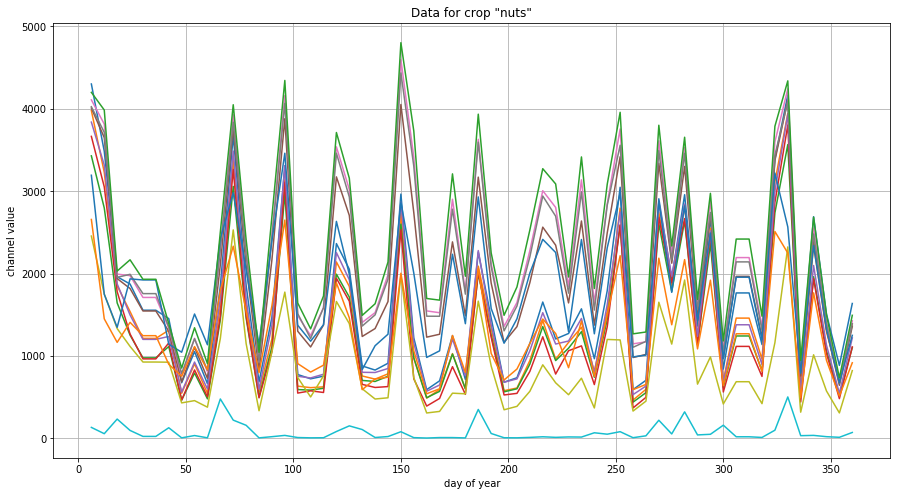

In [34]:
crop_index = 0

data_crop_x = selected_crops_data[crop_index]
data_crop_x_mean = np.mean(data_crop_x, axis=0)
data_crop_x_std = np.std(data_crop_x, axis=0)


plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(dates_list, data_crop_x_mean)
# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('channel value')
plt.title(f'Data for crop "{selected_crop_names[crop_index]}"')
plt.grid()





In [35]:
@dataclass
class CropNdviData:
    mean: np.ndarray
    std: np.ndarray

        
def get_ndvi_data(data_crop) -> CropNdviData:
    """
    data_crop: [fields (for the crop), time (dates_list), channels (bands B0-B12)]')
    return: mean and std for ndvi "channel"
    """
    
    # B8-B4 / (B8+B4)   ( counting from B1 to B13)
    B4 = data_crop[:, :, 4-1]
    B8 = data_crop[:, :, 8-1]

    data_crop_ndvi = (B8 - B4) / (B8 + B4)
    data_crop_mean_ndvi = np.mean(data_crop_ndvi, axis=0)
    data_crop_std_ndvi = np.std(data_crop_ndvi, axis=0) 
    
    return CropNdviData(mean=data_crop_mean_ndvi, std=data_crop_std_ndvi)
    

In [36]:
selected_crops_ndvi_data = [get_ndvi_data(crop_data) for crop_data in selected_crops_data]



/tmp/ipykernel_29228/4200634128.py:17: RuntimeWarning: invalid value encountered in true_divide
  data_crop_ndvi = (B8 - B4) / (B8 + B4)


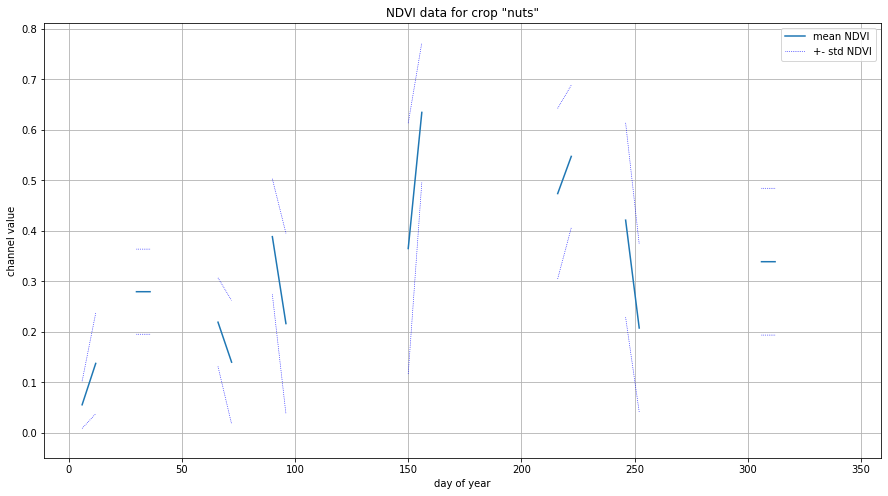

In [38]:
crop_index = 0

data_crop_x_mean_ndvi = selected_crops_ndvi_data[crop_index].mean
data_crop_x_std_ndvi = selected_crops_ndvi_data[crop_index].std


plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(dates_list, data_crop_x_mean_ndvi)
plt.plot(dates_list, data_crop_x_mean_ndvi - data_crop_x_std_ndvi, ':', color='b', linewidth=0.7)
plt.plot(dates_list, data_crop_x_mean_ndvi + data_crop_x_std_ndvi, ':', color='b', linewidth=0.7)

# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('channel value')
plt.title(f'NDVI data for crop "{selected_crop_names[crop_index]}"')
plt.grid()
plt.legend(['mean NDVI', '+- std NDVI'])

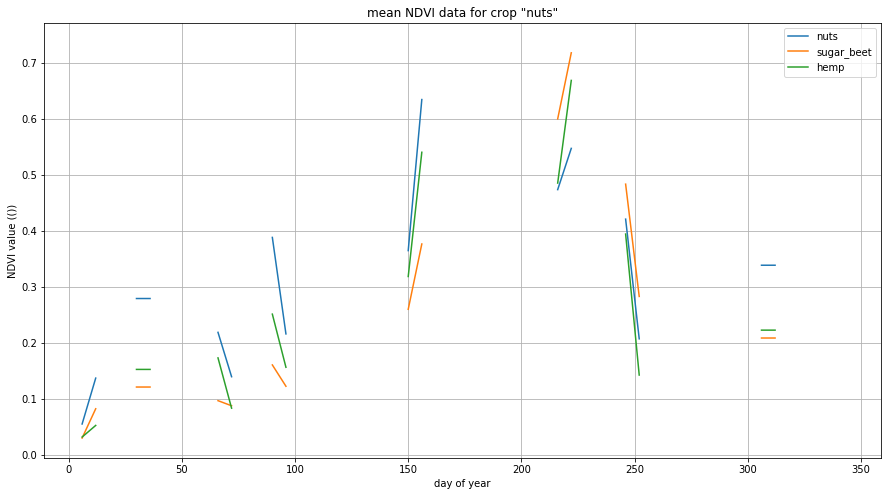

In [40]:
plt.rcParams['figure.figsize'] = [15, 8]

for crop_ndvi_data in selected_crops_ndvi_data:
    plt.plot(dates_list, crop_ndvi_data.mean)

# plt.legend(bands)
plt.style.use('_classic_test_patch')
plt.xlabel('day of year')
plt.ylabel('NDVI value (())')
plt.title(f'mean NDVI data for crop "{selected_crop_names[crop_index]}"')
plt.grid()
plt.legend(selected_crop_names)